In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy 
import scipy.io as sio
from scipy.interpolate import griddata
from scipy import optimize
from sklearn.metrics.pairwise import haversine_distances

%config InlineBackend.figure_format = "retina"

# Read Ozawa et al. (2011) coseismic and postseismic slip distributions and Loveless and Meade (2010) interseismic slip deficit distribution

In [2]:
df_coseismic = pd.read_csv("ozawa_coseismic_slip.csv")
df_coseismic["magnitude"] = np.sqrt(
    df_coseismic.ew.values**2.00 + df_coseismic.ns.values**2.00
)
df_postseismic = pd.read_csv("ozawa_postseismic_slip.csv")
df_postseismic["magnitude"] = np.sqrt(
    df_postseismic.ew.values**2.00 + df_postseismic.ns.values**2.00
)
df_interseismic = pd.read_csv("loveless_meade_coupling.csv")
df_interseismic["magnitude"] = np.sqrt(df_interseismic.ds_sd.values**2.00)

# Interpolate data onto regular grid and extract coseismic and postseismic slip along a single fault perpendicular profile

In [3]:
# Grid and interpolate the coseismic and postseismic slip distributions
lon_vec = np.linspace(139, 144, 100)
lat_vec = np.linspace(35, 42, 100)
lon_grid, lat_grid = np.meshgrid(lon_vec, lat_vec)
points = np.array([df_coseismic.longitude, df_coseismic.latitude]).T

grid_coseismic = griddata(
    points, df_coseismic.magnitude, (lon_grid, lat_grid), method="cubic"
)
grid_postseismic = griddata(
    points, df_postseismic.magnitude, (lon_grid, lat_grid), method="cubic"
)

grid_interseismic = griddata(
    np.array([df_interseismic.lon, df_interseismic.lat]).T,
    df_interseismic.magnitude,
    (lon_grid, lat_grid),
    method="cubic",
)

grid_coseismic[np.isnan(grid_coseismic)] = np.nanmin(grid_coseismic)
grid_postseismic[np.isnan(grid_postseismic)] = np.nanmin(grid_postseismic)
grid_interseismic[np.isnan(grid_interseismic)] = np.nanmin(grid_interseismic)

# Extract a profile line from the coseismic and postseismic data
start_point = (60, 30)
end_point = (40, 99)
n_profile = 10000
x_extract = np.linspace(start_point[0], end_point[0], n_profile)
y_extract = np.linspace(start_point[1], end_point[1], n_profile)
coseismic_profile = scipy.ndimage.map_coordinates(
    grid_coseismic, np.vstack((x_extract, y_extract))
)
postseismic_profile = scipy.ndimage.map_coordinates(
    grid_postseismic, np.vstack((x_extract, y_extract))
)
interseismic_profile = scipy.ndimage.map_coordinates(
    grid_interseismic, np.vstack((x_extract, y_extract))
)

# Postseismic / coseiseismic geometric moment ratio 

In [4]:
print(
    f"postseismic / coseismic = {np.sum(grid_postseismic) / np.sum(grid_coseismic) * 100:0.3}%"
)

postseismic / coseismic = 7.64%


# Plot slip distributions and profiles

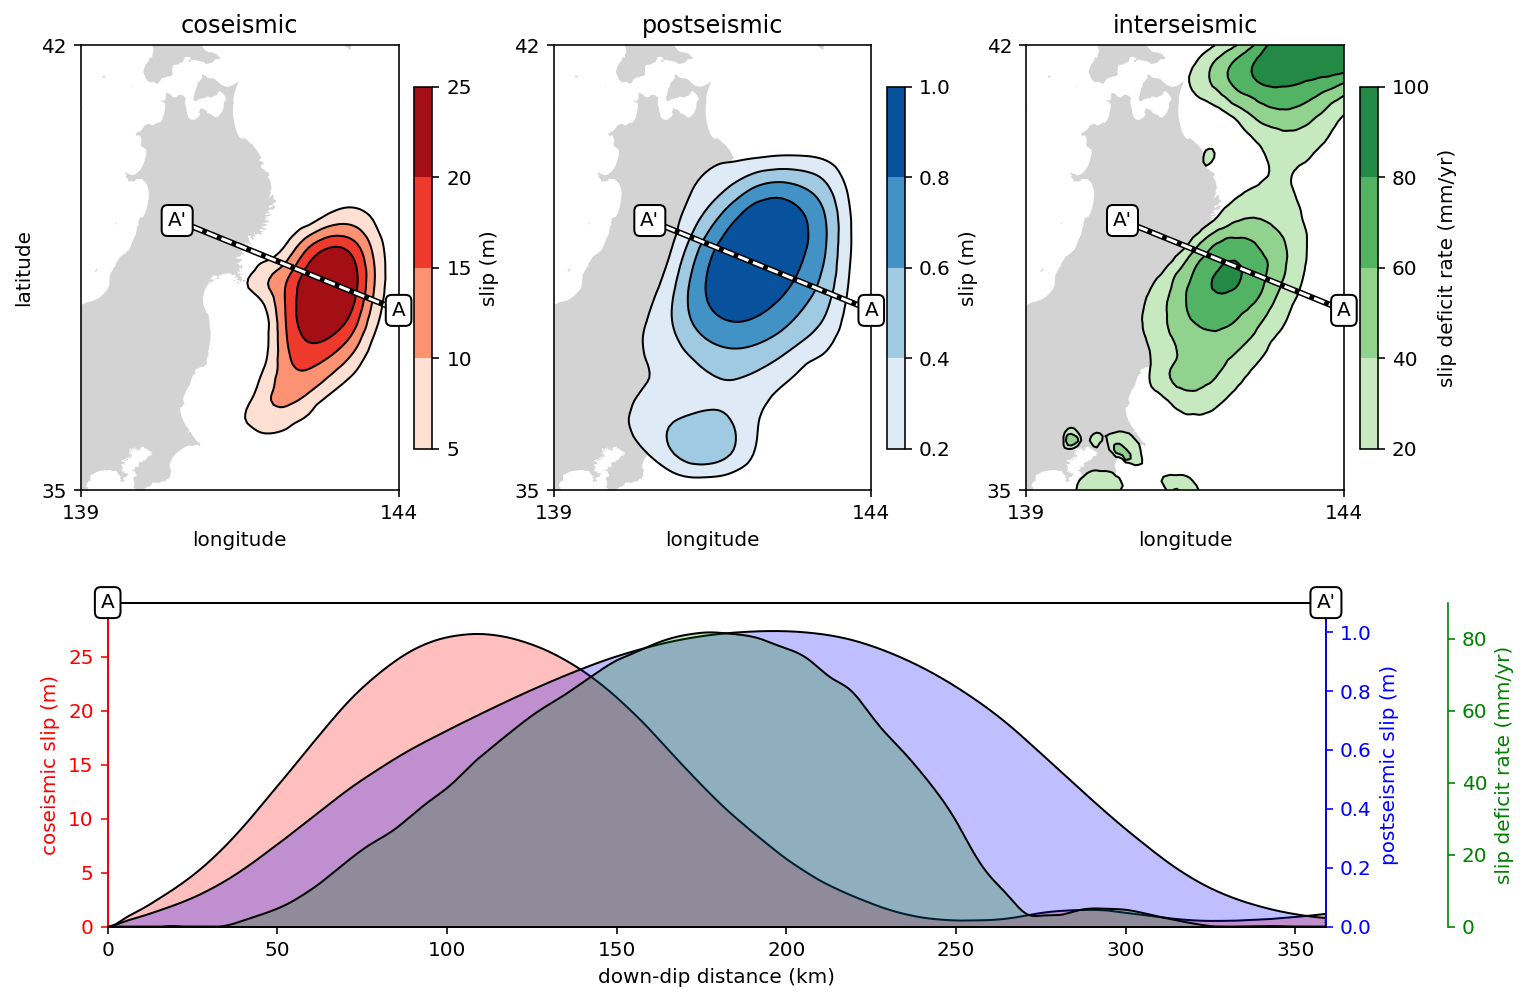

In [5]:
WORLD_BOUNDARIES = sio.loadmat("WorldHiVectors.mat")
RADIUS_EARTH = 6371
dip_approximate = np.deg2rad(18.0)
coseismic_color = "red"
postseismic_color = "blue"
interseismic_color = "green"

end_lat_lon = np.deg2rad(
    ([lat_grid[end_point[0], end_point[1]], lon_grid[end_point[0], end_point[1]]])
)
start_lat_lon = np.deg2rad(
    [lat_grid[start_point[0], start_point[1]], lon_grid[start_point[0], start_point[1]]]
)
profile_length = (
    RADIUS_EARTH
    / np.cos(dip_approximate)
    * haversine_distances([start_lat_lon, end_lat_lon])[0, 1]
)
x_position = np.copy(x_extract)
x_position = np.linspace(0, profile_length, n_profile)
x_position = np.flipud(x_position)

# Convert x_extract and y_extract to lon_extract and lat_extract.
lon_extract = np.linspace(
    lon_grid[start_point[0], start_point[1]],
    lon_grid[end_point[0], end_point[1]],
    n_profile,
)
lat_extract = np.linspace(
    lat_grid[start_point[0], start_point[1]],
    lat_grid[end_point[0], end_point[1]],
    n_profile,
)

plt.figure(figsize=(12, 9))
plt.subplot(2, 3, 1)
plt.fill(
    WORLD_BOUNDARIES["lon"],
    WORLD_BOUNDARIES["lat"],
    color="lightgray",
    linewidth=0.0,
    edgecolor="none",
)
levels = np.array([5, 10, 15, 20, 25])
grid_coseismic_plot = np.copy(grid_coseismic)
grid_coseismic_plot[grid_coseismic_plot > 25.0] = 25.0
plt.contourf(lon_grid, lat_grid, grid_coseismic_plot, levels=levels, cmap="Reds")
plt.colorbar(extend="both", label="slip (m)", fraction=0.046, pad=0.04)
plt.contour(
    lon_grid,
    lat_grid,
    grid_coseismic_plot,
    levels=levels,
    colors="k",
    linestyles="solid",
    linewidths=1.00,
)
plt.plot(lon_extract, lat_extract, "-k", linewidth=3.0)
plt.plot(lon_extract, lat_extract, "--w", linewidth=1.5)
props = dict(boxstyle="round", facecolor="white", alpha=1.0)
plt.text(
    lon_extract[0],
    lat_extract[0],
    "A'",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props,
)
plt.text(
    lon_extract[-1],
    lat_extract[-1],
    "A",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props,
)

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("coseismic")
plt.xlim([139, 144])
plt.ylim([35, 42])
plt.xticks([139, 144])
plt.yticks([35, 42])
plt.gca().set_aspect("equal", adjustable="box")

# Postseismic slip distribution
plt.subplot(2, 3, 2)
plt.fill(
    WORLD_BOUNDARIES["lon"],
    WORLD_BOUNDARIES["lat"],
    color="lightgray",
    linewidth=0.0,
    edgecolor="none",
)
levels = np.array([0.2, 0.4, 0.6, 0.8, 1.0])
grid_postseismic_plot = np.copy(grid_postseismic)
grid_postseismic_plot[grid_postseismic_plot > 1.0] = 1.0
plt.contourf(
    lon_grid,
    lat_grid,
    grid_postseismic_plot,
    levels=levels,
    cmap="Blues",
    vmin=0.2,
    vmax=1.0,
)
plt.colorbar(extend="both", label="slip (m)", fraction=0.046, pad=0.04)
plt.contour(
    lon_grid,
    lat_grid,
    grid_postseismic_plot,
    levels=levels,
    colors="k",
    linestyles="solid",
    linewidths=1.00,
)
plt.plot(lon_extract, lat_extract, "-k", linewidth=3.0)
plt.plot(lon_extract, lat_extract, "--w", linewidth=1.5)
plt.text(
    lon_extract[0],
    lat_extract[0],
    "A'",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props,
)
plt.text(
    lon_extract[-1],
    lat_extract[-1],
    "A",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props,
)
plt.xlabel("longitude")
plt.ylabel(" ")
plt.title("postseismic")
plt.xlim([139, 144])
plt.ylim([35, 42])
plt.xticks([139, 144])
plt.yticks([35, 42])
plt.gca().set_aspect("equal", adjustable="box")


# Interseismic coupling distribution
plt.subplot(2, 3, 3)
plt.fill(
    WORLD_BOUNDARIES["lon"],
    WORLD_BOUNDARIES["lat"],
    color="lightgray",
    linewidth=0.0,
    edgecolor="none",
)
levels = np.linspace(20, 100, 5)
grid_interseismic_plot = np.copy(grid_interseismic)
grid_interseismic_plot[grid_interseismic_plot > 100.0] = 100.0
plt.contourf(
    lon_grid,
    lat_grid,
    grid_interseismic_plot,
    levels=levels,
    cmap="Greens",
    vmin=0.0,
    vmax=120.0,
)
plt.colorbar(extend="both", label="slip deficit rate (mm/yr)", fraction=0.046, pad=0.04)
plt.contour(
    lon_grid,
    lat_grid,
    grid_interseismic_plot,
    levels=levels,
    colors="k",
    linestyles="solid",
    linewidths=1.00,
)
plt.plot(lon_extract, lat_extract, "-k", linewidth=3.0)
plt.plot(lon_extract, lat_extract, "--w", linewidth=1.5)
plt.text(
    lon_extract[0],
    lat_extract[0],
    "A'",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props,
)
plt.text(
    lon_extract[-1],
    lat_extract[-1],
    "A",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props,
)
plt.xlabel("longitude")
plt.ylabel(" ")
plt.title("interseismic")
plt.xlim([139, 144])
plt.ylim([35, 42])
plt.xticks([139, 144])
plt.yticks([35, 42])
plt.gca().set_aspect("equal", adjustable="box")


# Coseismic profile
ax1 = plt.axes(position=[0.165, 0.2, 0.705, 0.25])
coseismic_profile[coseismic_profile < 0] = 0
coseismic_profile[0] = 0
coseismic_profile[-1] = 0
ax1.fill(
    x_position, coseismic_profile, color=coseismic_color, alpha=0.25, edgecolor="none"
)
ax1.plot(x_position, coseismic_profile, color="k", linewidth=1.0, zorder=20)
plt.yticks([0.0, 5.0, 10.0, 15.0, 20.0, 25.0])
ax1.set_ylabel("coseismic slip (m)", color=coseismic_color)
ax1.set_xlabel("down-dip distance (km)")
ax1.tick_params(axis="y", color=coseismic_color, labelcolor=coseismic_color)
plt.xlim([np.min(x_position), np.max(x_position)])
plt.gca().set_ylim(bottom=0.0, top=30.0)

# Postseismic profile
ax2 = ax1.twinx()
postseismic_profile[postseismic_profile < 0] = 0
postseismic_profile[0] = 0
postseismic_profile[-1] = 0
ax2.fill(
    x_position,
    postseismic_profile,
    color=postseismic_color,
    alpha=0.25,
    edgecolor="none",
)
ax2.plot(
    x_position,
    postseismic_profile,
    color="k",
    linewidth=1.0,
)
ax2.set_ylabel("postseismic slip (m)", color=postseismic_color)
ax2.tick_params(axis="y", color=postseismic_color, labelcolor=postseismic_color)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.gca().set_ylim(bottom=0.0, top=1.1)
ax2.spines["left"].set_color(coseismic_color)
ax2.spines["right"].set_color(postseismic_color)

# Interseismic profile
ax3 = ax1.twinx()
interseismic_profile[interseismic_profile < 0] = 0
interseismic_profile[0] = 0
interseismic_profile[-1] = 0
ax3.fill(
    x_position,
    interseismic_profile,
    color=interseismic_color,
    alpha=0.25,
    edgecolor="none",
)
ax3.plot(
    x_position,
    interseismic_profile,
    color="k",
    linewidth=1.0,
)
plt.text(
    0,
    90,
    "A",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props,
    zorder=1e8,
)
plt.text(
    x_position[0],
    90,
    "A'",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props,
)
ax3.set_ylabel("slip deficit rate (mm/yr)", color=interseismic_color)
ax3.tick_params(axis="y", color=interseismic_color, labelcolor=interseismic_color)
plt.yticks([0.0, 20, 40, 60, 80])
plt.gca().set_ylim(bottom=0.0, top=90)
ax3.spines.right.set_position(("axes", 1.1))
ax3.spines["left"].set_color(coseismic_color)
ax3.spines["right"].set_color(interseismic_color)

# plt.savefig("japan_sz_distributions.png", dpi=500, bbox_inches="tight")
# plt.savefig("japan_sz_distributions.pdf")

# Hand-tuned kinematic afterslip model

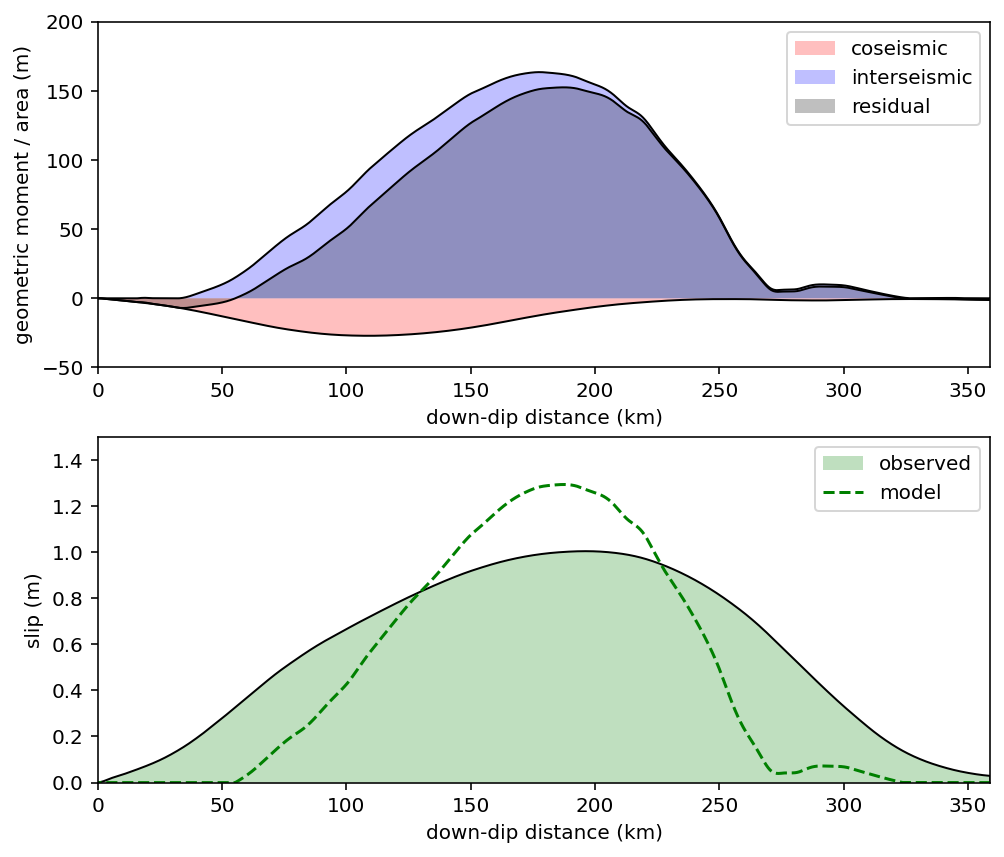

<Figure size 432x288 with 0 Axes>

In [6]:
def calc_V(c, gamma, m_coseismic, g, h, f):
    numerator = c**2 * gamma * m_coseismic
    denominator = np.sum(g * h / f)
    V = numerator / denominator
    return V


def calc_v0(V, g, h):
    v0 = V * g * h
    return v0


def calc_m_afterslip(gamma, m_coseismic, g, h, f):
    numerator = gamma * g * h * m_coseismic
    denominator = f * np.sum(g * h / f)
    m_afterslip = numerator / denominator
    return m_afterslip


# Basics
Y2S = 365.25 * 24 * 60 * 60
MM2M = 1e-3
KM2M = 1e3
gamma = 0.076  # Tohoku specific from Ozawa
gamma = 0.2  # Tohoku specific from Ozawa
c = 0.00001
accumulation_years = 2000

segment_area = np.abs(x_position[1] - x_position[0]) * KM2M
coseismic_geometric_moment = coseismic_profile * segment_area
interseismic_geometric_moment_rate = interseismic_profile * segment_area
accumulated_interseismic_geometric_moment = (
    interseismic_geometric_moment_rate * accumulation_years * MM2M
)
residual_geometric_moment_full = (
    accumulated_interseismic_geometric_moment - coseismic_geometric_moment
)
residual_geometric_moment = np.copy(residual_geometric_moment_full)
residual_geometric_moment[residual_geometric_moment < 1e-16] = 1e-16
m_coseismic = np.sum(coseismic_geometric_moment / segment_area)

# Core function choices
f = residual_geometric_moment
g = residual_geometric_moment**1.0
h = m_coseismic

# Core function choices
f = residual_geometric_moment**1.0
g = residual_geometric_moment**1.0
h = m_coseismic**1.0

# Initial conditions
V = calc_V(c, gamma, m_coseismic, g, h, f)
v0 = calc_v0(V, g, h)
t = 0.0 * Y2S
c = 1e-5

v_afterslip = v0 * np.exp(-(c**2.0) * f * segment_area * t)
v_afterslip = v_afterslip * Y2S  # Convert from m/s to m/yr
OZAWA_AFTERSLIP_DURATION = (
    14 / 365
)  # From March 11, 2011 to March 25, 2011 (Ozawa et al., 2011, figure S1 catopn)
v_afterslip = (
    v_afterslip * OZAWA_AFTERSLIP_DURATION
)  # Convert from m/yr to m/two weeks which is the Ozawa observation epoch


plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.plot(
    x_position, -1 * coseismic_geometric_moment / segment_area, "-k", linewidth=1.0
)
plt.fill(
    x_position,
    -1 * coseismic_geometric_moment / segment_area,
    color="red",
    alpha=0.25,
    edgecolor="none",
    label="coseismic",
)
plt.plot(
    x_position,
    accumulated_interseismic_geometric_moment / segment_area,
    "-k",
    linewidth=1.0,
)
plt.fill(
    x_position,
    accumulated_interseismic_geometric_moment / segment_area,
    color="blue",
    alpha=0.25,
    edgecolor="none",
    label="interseismic",
)
plt.plot(x_position, residual_geometric_moment_full / segment_area, "-k", linewidth=1.0)
plt.fill(
    x_position,
    residual_geometric_moment_full / segment_area,
    color="k",
    alpha=0.25,
    edgecolor="none",
    label="residual",
)

plt.legend()
plt.xlim([np.min(x_position), np.max(x_position)])
plt.ylim([-50, 200])
plt.ylabel("geometric moment / area (m)")
plt.xlabel("down-dip distance (km)")

plt.subplot(2, 1, 2)
plt.plot(x_position, postseismic_profile, "-k", linewidth=1.0)
plt.fill(
    x_position,
    postseismic_profile,
    color="g",
    alpha=0.25,
    edgecolor="none",
    label="observed",
)

plt.plot(x_position, v_afterslip, "--g", label="model")
plt.legend()
plt.xlim([np.min(x_position), np.max(x_position)])
plt.ylim([0, 1.5])
plt.ylabel("slip (m)")
plt.xlabel("down-dip distance (km)")
plt.show()

plt.savefig("japan_afterslip_model.png", dpi=500, bbox_inches="tight")
plt.savefig("japan_afterslip_model.pdf")

In [7]:
# Things to estimate:
def objective_function(params):
    (
        power_law_exponent_f,
        power_law_exponent_g,
        power_law_exponent_h,
    ) = params

    f = residual_geometric_moment**power_law_exponent_f
    g = residual_geometric_moment**power_law_exponent_g
    h = m_coseismic**power_law_exponent_h

    # Initial conditions
    V = calc_V(c, gamma, m_coseismic, g, h, f)
    v0 = calc_v0(V, g, h)
    v_afterslip = v0
    v_afterslip = v_afterslip * Y2S  # Convert from m/s to m/yr
    v_afterslip = (
        v_afterslip * OZAWA_AFTERSLIP_DURATION
    )  # Convert from m/yr m/two weeks which is the Ozawa observation epoch

    predicted_postseismic_profile = v_afterslip
    return np.sum(np.abs(predicted_postseismic_profile - postseismic_profile))


# Estimate best fitting parameters
accumulation_years = 2000
accumulated_interseismic_geometric_moment = (
    interseismic_geometric_moment_rate * accumulation_years * MM2M
)
residual_geometric_moment = (
    accumulated_interseismic_geometric_moment - coseismic_geometric_moment
)
residual_geometric_moment[residual_geometric_moment < 1e-16] = 1e-16


parameter_ranges = (
    slice(0.1, 3, 0.25),
    slice(0.1, 3, 0.25),
    slice(0.1, 3, 0.25),
)
brute_output = optimize.brute(objective_function, parameter_ranges, finish=None)
print(f"{brute_output=}")

# Evaluate forward model with best-fit parameters
best_fit_afterslip_profile = np.zeros_like(postseismic_profile)


# Plot observed vs. best-fit profile

brute_output=array([0.85, 1.85, 1.1 ])
